In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFViTModel
from PIL import Image

from utils import *
from dataset import *
from data_aug import *

c:\anaconda\envs\transformers2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image1_array, image2_array, labels = load_data("Mapillary/mapillary_training_dataaug_contrast/")

batch_size = 16

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [3]:
resize_rescale_hf = tf.keras.Sequential([
    tf.keras.layers.Permute((3, 1, 2))
])

In [4]:
def create_siamese_network(input_shape):
    input_1 = layers.Input(shape=input_shape)
    resized_input_1 = resize_rescale_hf(input_1)  # Make sure resize_rescale_hf is defined or imported
    input_2 = layers.Input(shape=input_shape)
    resized_input_2 = resize_rescale_hf(input_2)  # Make sure resize_rescale_hf is defined or imported
    
    # Load the ViT model for image classification
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    for layer in base_model.layers:
        layer.trainable=True

    print(len(base_model.layers))
    # Extract the features from the ViT model
    features_1 = base_model.vit(resized_input_1)[0][:, 0, :]
    features_2 = base_model.vit(resized_input_2)[0][:, 0, :]

    # Calculate the Euclidean distance between the representations of the two images
    distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([features_1, features_2])
    outputs = layers.Dense(2, activation='softmax')(distance)

    # Create the Keras model
    siamese_network = tf.keras.Model(inputs=[input_1, input_2], outputs=outputs)

    return siamese_network

def run_siamese_experiment(model, train_generator, valid_generator, train_steps_per_epoch, valid_steps_per_epoch, num_epochs):
    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    history = model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=200,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

    return history

input_shape = (224, 224, 3)

siamese_network = create_siamese_network(input_shape)
siamese_network.summary()
history = run_siamese_experiment(siamese_network, train_generator, valid_generator, train_steps_per_epoch, valid_steps_per_epoch,50)


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 3, 224, 224)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
vit (TFViTMainLayer)            TFBaseModelOutputWit 86389248    sequential[0][0]           

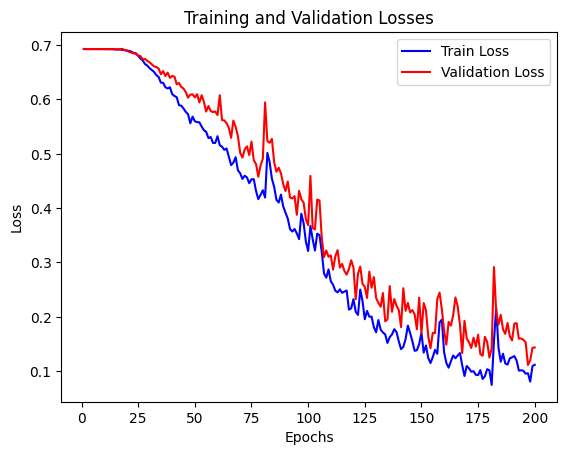

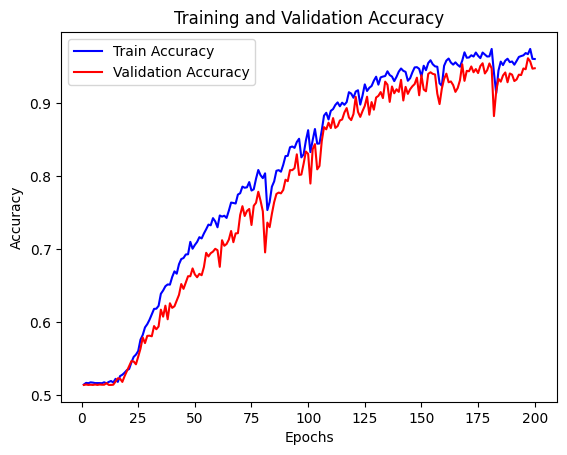

In [5]:
plot_loss(history)
plot_accuracy(history)
siamese_network.save("transformer.h5")

In [6]:
siamese_network.evaluate(test_generator, steps=valid_steps_per_epoch)

228/228 [==============================] - 52s 226ms/step - loss: 0.0586 - accuracy: 0.9814


[0.05862326920032501, 0.9813596606254578]

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Subtract, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
image1_array, image2_array, labels = load_data("Mapillary/mapillary_training_dataaug_contrast/")

batch_size = 16

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "ranking")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [7]:
def create_ranking_network(img_size):
    """
    Create ranking network which give a score to an image.

    :param img_size: size of input images during training
    :type img_size: tuple(int)
    :return: ranking network model
    :rtype: keras.Model
    """
    # Create feature extractor from VGG19
    feature_extractor = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    for layer in feature_extractor.layers:
        layer.trainable=True

    # Add dense layers on top of the feature extractor
    inp = Input(shape=(img_size, img_size, 3), name='input_image')
    resized_inp = resize_rescale_hf(inp) 
    base = feature_extractor.vit(resized_inp)[0][:, 0, :]
    base = Flatten(name='Flatten')(base)

    # Block 1
    base = Dense(32, activation='sigmoid', name='Dense_1')(base)
    base = BatchNormalization(name='BN1')(base)
    base = Dropout(0.2, name='Drop_1')(base)

    # Block 2
    base = Dense(32, activation='sigmoid', name='Dense_2')(base)
    base = BatchNormalization(name='BN2')(base)
    base = Dropout(0.2, name='Drop_2')(base)

    # Final dense
    base = Dense(1, name="Dense_Output")(base)
    base_network = Model(inp, base, name='Scoring_model')
    return base_network


def create_meta_network(img_size, weights=None):
    """
    Create meta network which is used to to teach the ranking network.

    :param img_size: dimension of input images during training.
    :type img_size: tuple(int)
    :param weights: path to the weights use for initialization
    :type weights: str
    :return: meta network model
    :rtype: keras.Model
    """

    # Create the two input branches
    input_left = Input(shape=(img_size, img_size, 3), name='left_input')
    input_right = Input(shape=(img_size, img_size, 3), name='right_input')
    base_network = create_ranking_network(img_size)
    left_score = base_network(input_left)
    right_score = base_network(input_right)

    # Subtract scores
    diff = Subtract()([left_score, right_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid", name="Activation_sigmoid")(diff)
    model = Model(inputs=[input_left, input_right], outputs= prob, name="Meta_Model")

    if weights:
        print('Loading weights ...')
        model.load_weights(weights)

    model.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-05), loss="binary_crossentropy", metrics=['accuracy'])

    return model

meta_model = create_meta_network(224)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [8]:
history = meta_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=30,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

Epoch 1/30
684/684 [==============================] - 519s 741ms/step - loss: 0.6012 - accuracy: 0.7196 - val_loss: 0.4254 - val_accuracy: 0.8114
Epoch 2/30
684/684 [==============================] - 503s 736ms/step - loss: 0.4138 - accuracy: 0.8179 - val_loss: 0.3091 - val_accuracy: 0.8805
Epoch 3/30
684/684 [==============================] - 503s 735ms/step - loss: 0.3154 - accuracy: 0.8708 - val_loss: 0.1834 - val_accuracy: 0.9345
Epoch 4/30
684/684 [==============================] - 503s 736ms/step - loss: 0.2109 - accuracy: 0.9182 - val_loss: 0.1175 - val_accuracy: 0.9627
Epoch 5/30
684/684 [==============================] - 503s 735ms/step - loss: 0.1620 - accuracy: 0.9396 - val_loss: 0.0975 - val_accuracy: 0.9682
Epoch 6/30
684/684 [==============================] - 503s 735ms/step - loss: 0.1360 - accuracy: 0.9487 - val_loss: 0.0923 - val_accuracy: 0.9720
Epoch 7/30
684/684 [==============================] - 503s 735ms/step - loss: 0.1163 - accuracy: 0.9596 - val_loss: 0.0663 -

c:\anaconda\envs\transformers2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


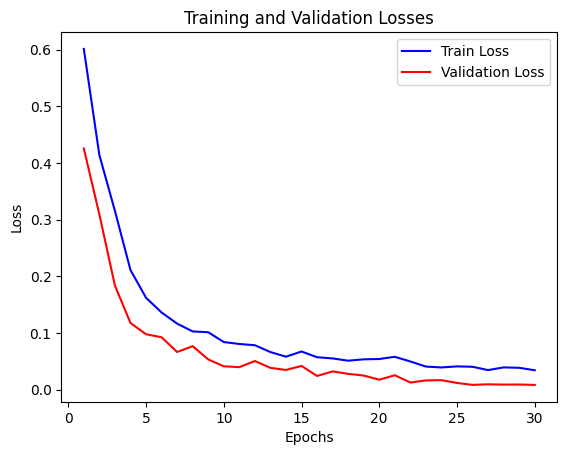

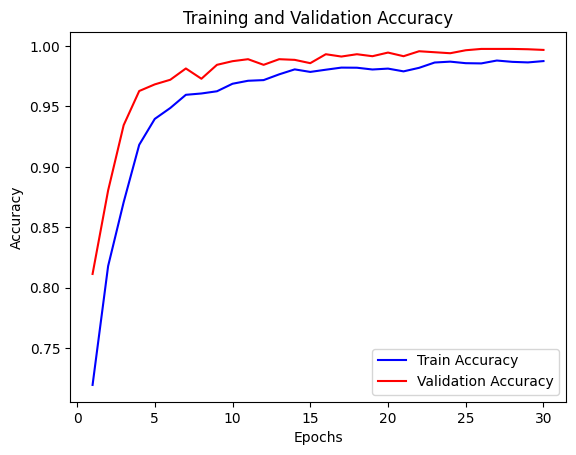

In [9]:
meta_model.save("meta_model_wieght.h5")
ranking_model = meta_model.get_layer('Scoring_model')
ranking_model.save_weights('ranking_model_weights.h5')
plot_loss(history)
plot_accuracy(history)